In [ ]:
import pandas as pd
import numpy as np
import askAtRandom
import Session
L = Session.Session()
L.start_session()
L.students.head()

In [1]:
# L.ask()

In [ ]:
L.end_session()

# Lecture 4: (non)Linear Programing, Constrained Maximization

## Let's go through the homework:

You manage a two-product firm. The production technology requires a mixture of
capital and labor to produce each product. Capital is shared, while labor is
specific to each of the two products. For the first product, capital ($K \geq
0$) and labor ($L_1 \geq 0$) must satisfy the following, in order to produce
$q_1$ units: $q_{1} \leq \sqrt{KL_{1}}$. Likewise, producing $q_2$ units of the
second product requires capital ($K$) and labor (now $L_2 \geq 0$) such that:
$q_2 \leq\sqrt{KL_2}$. In addition, total capital is limited to a maximum of
200 units. (So $K \leq 200$.) Naturally, $K$, $L_1$, $L_2$ are all required to
be non-negative. Capital costs 100 per unit, labor for the first product costs
140 per unit and labor for the second product costs 175 per unit. The first
product sells for 275 per unit, and the second sells for 300 per unit.


1. Initially suppose only the first product is present. Determine and interpret your optimal production plan.
2. Next suppose only the second product is present. Determine and interpret your optimal production plan.
3. Now assume both products are present. Determine and interpret your optimal production plan.
4. Repeat the three parts above assuming the first product sells for 200 per unit.
5. Fill in the following table:

| $q_1$ | $q_2$ | MC of $q_1$ with $q_2$ fixed. | MC of $q_2$ with $q_1$ fixed. |
|:-----:|:-----:|:-----------------------------:|:-----------------------------:|
|   50  |   50  |                               |                               |
|   50  |  100  |                               |                               |
|   50  |  150  |                               |                               |
|  100  |   50  |                               |                               |
|  100  |  100  |                               |                               |
|  100  |  150  |                               |                               |
|  150  |  100  |                               |                               |
|  150  |  150  |                               |                               |

(_MC is the marginal cost_)


<!-- ### Three quick points based on common questions:  -->
<!-- 1. The cost of capital is 100 per unit, so if the constraint binds total cost of capital is 100 $\times$ 200 = 20,000 -->

### What are $q_{1} \leq \sqrt{KL_{1}}$ and $q_2 \leq\sqrt{KL_2}$?

- Notice that this even though there is a $\leq$ sign, that this is not a constraint _per se_ because we get to choose $K$ and $L_1$, and it is only that choice that constrains the amount of $q_1$ that we produce.
- Also notice that if we are trying to optimize we will never produce less than $q_1=\sqrt{KL_{1}}$
- The expression $q_{1} \leq \sqrt{KL_{1}}$ is that rate at which our production process changes in puts into outputs.
- A name for this sort of function is a "__production function__"

Let's look at some plots to see the implications of this.
__Note that I'll use python for the examples today, this is because it makes plotting easy, and I want you to think of these as list of steps. I will provide excel examples later, but for now I want us to concentrate on the steps.__

In [2]:
# quick set up for our plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# create the framework for our plot
l1 = np.linspace(0, 300, 300)
k = np.linspace(0, 200, 300)
L1, K = np.meshgrid(l1, k)

# CALCULATE THE PRODUCTION FUNCTION 
Q1 = np.sqrt(L1*K)

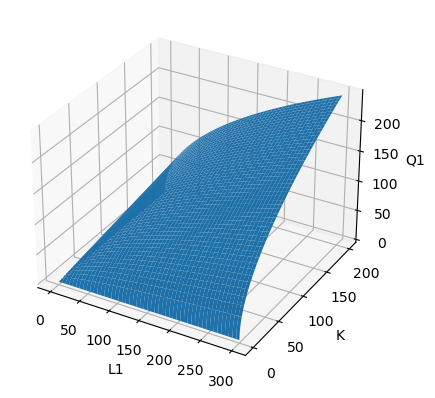

In [3]:
# Create the figure and add a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the data
ax.plot_surface(L1, K, Q1)
# Set axis labels and show the plot
ax.set_xlabel('L1')
ax.set_ylabel('K')
ax.set_zlabel('Q1')
plt.show()

### What if we hold K fixed? What will the graph look like?

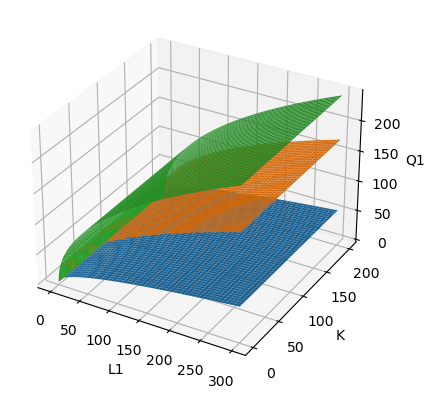

In [4]:
l1 = np.linspace(0, 300, 300)
Q1_10 = np.sqrt(L1*10)
Q1_100 = np.sqrt(L1*100)
Q1_200 = np.sqrt(L1*200)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(L1, K, Q1_10)
ax.plot_surface(L1, K, Q1_100)
ax.plot_surface(L1, K, Q1_200)
ax.set_xlabel('L1')
ax.set_ylabel('K')
ax.set_zlabel('Q1')
plt.show()

### Optimal production plan for $q_1$ alone:

Let's refer to the prices as "P", and the labor and capital costs as "C"
$$ \Pi(P,C) \equiv 275 \times q_1 - 140 \times L_1 - 100 \times K $$
$$ q_1 \leq \sqrt{L_1 \times K} $$
$$ K \leq \bar{K} = 200 $$

This makes it seem like we have more choices than we actually have. The constraint (production function) makes it so that we can only choose two of K, q1, and l1.

$$ \Pi(P,C) \equiv 275 \times q_1 - 140 \times \frac{q_1^2}{K} - 100 \times K $$
$$ K \leq \bar{K} = 200 $$

### So what do we do with this?
$$ \Pi(P,C) \equiv 275 \times q_1 - 140 \times \frac{q_1^2}{K} - 100 \times K $$
$$ K \leq \bar{K} = 200 $$

How do we choose the optimal production plan?

There are a number of approaches, I'm going to show you a very general python solver. This will be useful for those of you that are using python, I want the rest of you to focus on the steps we are taking so you can apply them to whatever solver you like. (Excel example will be posted soon)

## Since this is not a linear problem let's use [GEKKO](https://gekko.readthedocs.io/en/latest/)

In [5]:
# set up the solver
from gekko import GEKKO
m = GEKKO(remote=False)

### Step 1: Choice Variables and their constraints

In [6]:
# Initialize the decision variables
q1 = m.Var(
    name="q1", 
    lb=0 # the lower bound
)
q1.value=1 # most solvers run faster when you give a starting point

k =  m.Var(
    name="k", 
    lb=0, # lower bound
    ub=200 # upper bound
) 
k.value=200 # this is our first guess to speed up the solution

### Step 2: Write down the objective function (what we want to maximize), any remaining constraints, and solve.
$$ \Pi(P,C) \equiv 275 \times q_1 - 140 \times \frac{q_1^2}{K} - 100 \times K $$
_What happened to $ K \leq \bar{K} = 200 $?_

In [7]:
m.Maximize(
    275*q1 - 140*((q1**2)/k) - 100*k
)
m.solve(disp=False) # silencing the out put because it is diagnostic

The output from the model is just the choice variables so we need to calculate profit and labor:

In [8]:
profit = (275*q1.value[0] - 140*((q1.value[0]**2)/k.value[0]) - 100*k.value[0])
l1 = q1.value[0]**2/k.value[0]

### This gives us the following solutions 
(note that I'm rounding here)

In [9]:
print('q1     ', int(q1.value[0]))
print('l1     ',int(l1))
print('K      ', int(k.value[0]))
print('profit ', int(profit))

q1      196
l1      192
K       200
profit  7008


### Optimal production plan for $q_2$ alone:
Let's refer to the prices as "P", and the labor and capital costs as "C"
$$ \Pi(P,C) \equiv + 300 \times q_2  - 170 \times L_2 - 100 \times K $$
$$ q_2 \leq \sqrt{L_2 \times K} $$
$$ K \leq \bar{K} = 200 $$

We make a similar substitution here:

$$ \Pi(P,C) \equiv + 300 \times q_2  - 170 \times \frac{q_1^2}{K} - 100 \times K $$
$$ K \leq \bar{K} = 200 $$

In [10]:
# same set up repeated to clean out 'm'
m = GEKKO(remote=False)
q2 = m.Var(name="q2", lb=0)
q2.value=1
k =  m.Var(name="k", lb=0, ub=200)
k.value=200 

### Write down the objective function again and solve:
$$ \Pi(P,C) \equiv + 300 \times q_2  - 170 \times \frac{q_1^2}{K} - 100 \times K $$

In [11]:
m.Maximize(
    300*q2 - 175*((q2**2)/k) - 100*k
)
m.solve(disp=False)
profit = (300*q2.value[0] - 175*((q2.value[0]**2)/k.value[0]) - 100*k.value[0])
l2 = q2.value[0]**2/k.value[0]

### This gives us the following solutions 
(note that I'm rounding here)

In [12]:
print('q2     ', int(q2.value[0]))
print('l2     ',int(l2))
print('K      ', int(k.value[0]))
print('profit ', int(profit))

q2      171
l2      146
K       200
profit  5714


### Optimal production plan for both:
Let's refer to the prices as "P", and the labor and capital costs as "C"
$$ \Pi(P,C) \equiv 275 \times q_1 + 300 \times q_2 - 140 \times L_1 - 170 \times L_2 - 100 \times K $$
$$ q_1 \leq \sqrt{L_1 \times K} $$
$$ q_2 \leq \sqrt{L_2 \times K} $$
$$ K \leq \bar{K} = 200 $$

Again both constraints allow us to eliminate $L_1$:
$$ \Pi(P,C) \equiv 275 \times q_1 + 300 \times q_2 - 140 \times \frac{q_1^2}{K} - 170 \times \frac{q_1^2}{K} - 100 \times K $$
$$ K \leq \bar{K} = 200 $$

In [13]:
# reset gekko
m = GEKKO(remote=False)
# Initialize the decision variables
q1 = m.Var(name="q1", lb=0)
q1.value=1
q2 = m.Var(name="q2", lb=0)
q2.value=1
k =  m.Var(name="k", lb=0, ub=200) 
k.value=200

In [14]:
# write the objective function  and solve
m.Maximize(
    275*q1 - 140*((q1**2)/k)
    + 300*q2 - 175*((q2**2)/k)
    - 100*k
)
m.solve(disp=False)

In [15]:
# quick calcs to clean things up
profit = (
    275*q1.value[0] - 140*((q1.value[0]**2)/k.value[0]) 
    + 300*q2.value[0] - 175*((q2.value[0]**2)/k.value[0])  
    - 100*k.value[0]
)
l1 = q1.value[0]**2/k.value[0]
l2 = q2.value[0]**2/k.value[0]


### This gives us the following solutions 
(note that I'm rounding here)

In [16]:
print('q1     ', int(q1.value[0]))
print('l1     ',int(l1))
print('q2     ', int(q2.value[0]))
print('l2     ',int(l2))
print('K      ', int(k.value[0]))
print('profit ', int(profit))

q1      196
l1      192
q2      171
l2      146
K       200
profit  32723


### We always pick k=200. What does this mean?

- This means that the capital constraint is preventing us from making the next unit.
- When a constraint does this we often call it a binding constraint.

### The q1,L1 and q2,L2 pairs that we pick are the same when we consider the products separately and together. What does this mean?

- It means that the profit function is __separable__ when the capital constraint is binding.


### Repeat all three steps with $P_1=200$

In [17]:
m = GEKKO(remote=False)
q1 = m.Var(name="q1", lb=0)
q1.value=1
q2 = m.Var(name="q2", lb=0)
q2.value=1
k =  m.Var(name="k", lb=0, ub=200)
k.value=200 
m.Maximize(
    200*q1 - 140*((q1**2)/k) - 100*k
)
m.solve(disp=False) # silencing the out put because it is diagnostic
profit = (
    200*q1.value[0] 
    - 140*((q1.value[0]**2)/k.value[0]) 
    - 100*k.value[0]
)
l1 = q1.value[0]**2/k.value[0]

###  $Q_1$ when $P_1=200$

In [18]:
print('q1     ', int(q1.value[0]))
print('l1     ',int(l1))
print('K      ', int(k.value[0]))
print('profit ', int(profit))

q1      0
l1      0
K       0
profit  0


### The optimal amount of Q1 to produce is 0.

What does this mean?

What does this mean?
This means that a firm that only produces Q1 should not produce it at this price, given this cost structure.
What does this mean for a firm that produces Q2? 
What should they do? enter the market for Q1 or not?

### Lets look at the profit functions for the two single product firms with k=200

In [19]:
# set up
def Pi1(q1):
    return 200*q1 - 140*((q1**2)/200) 
def Pi2(q2):
    return 300*q2 - 175*((q2**2)/200) 
q1=np.linspace(0,300,300)
q2=np.linspace(0,300,300)

Pq1=Pi1(q1)- 100*200
Pq2=Pi2(q2)- 100*200

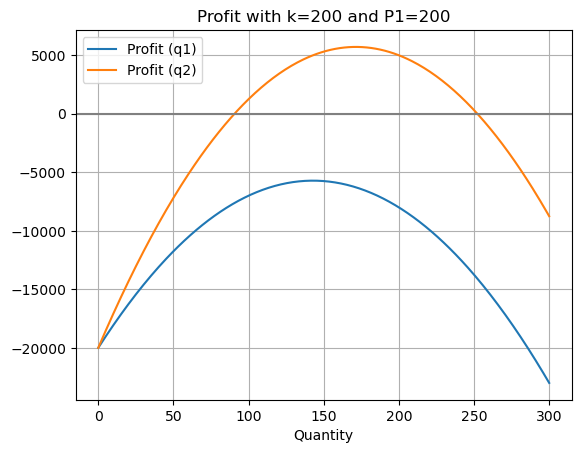

In [20]:
plt.plot(q1,Pq1,label='Profit (q1)')
plt.plot(q1,Pq2,label='Profit (q2)')
plt.xlabel('Quantity')
plt.legend()
plt.grid()
plt.axhline(0, color='grey')
plt.title('Profit with k=200 and P1=200')
plt.show()

###  $Q_1$ and $Q_2$ when $P_1=200$ 
Now we are back to the multiproduct firm

In [21]:
# Let's look at the two together
# reset gekko
m = GEKKO(remote=False)
# Initialize the decision variablesc
q1 = m.Var(name="q1", lb=0)
q1.value=1
q2 = m.Var(name="q2", lb=0)
q2.value=1
k =  m.Var(name="k", lb=0, ub=200) # this is the constraint
k.value=200 # this is our first guess to speed up the solution
m.Maximize(
200*q1 - 140*((q1**2)/k)
+ 300*q2 - 175*((q2**2)/k)
- 100*k
)
m.solve(disp=False)
profit = (
    200*q1.value[0] - 140*((q1.value[0]**2)/k.value[0]) 
    + 300*q2.value[0] - 175*((q2.value[0]**2)/k.value[0])  
    - 100*k.value[0]
)
l1 = q1.value[0]**2/k.value[0]
l2 = q2.value[0]**2/k.value[0]

In [22]:
print('q1     ', int(q1.value[0]))
print('l1     ',int(l1))
print('q2     ', int(q2.value[0]))
print('l2     ',int(l2))
print('K      ', int(k.value[0]))
print('profit ', int(profit))

q1      142
l1      102
q2      171
l2      146
K       200
profit  20000


### Lets plot this and see what it's telling us.

In [23]:
# Create data for the plot
def bigPi(q1,q2,k=200):
    return 200*q1 - 140*((q1**2)/k)+ 300*q2 - 175*((q2**2)/k) - 100*k
q1=np.linspace(0,300,300)
q2=np.linspace(0,300,300)
Q1, Q2 = np.meshgrid(q1, q2)
Pi12 = bigPi(Q1,Q2)

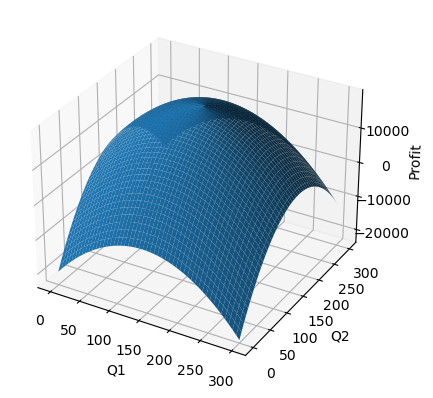

In [24]:
# Create the figure and add a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the data
ax.plot_surface(Q1, Q2, Pi12)
# Set axis labels and show the plot
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
ax.set_zlabel('Profit')
plt.show()

### Let's zoom to the zero lower bound

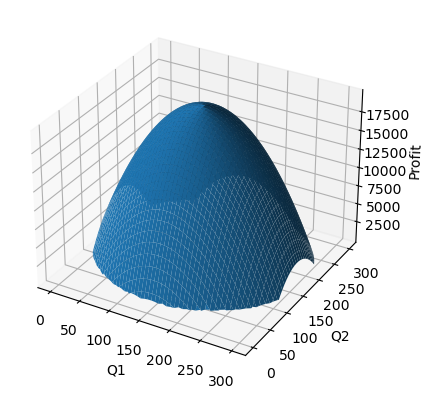

In [25]:
Profit =  np.where(Pi12>0,Pi12,np.nan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Q1, Q2, Profit)
ax.set_xlabel('Q1')
ax.set_ylabel('Q2')
ax.set_zlabel('Profit')
plt.show()

 ### What interesting insights or questions jump out from these facts?

- Now there is some synergy!
- The functions are no longer separable
 
## Why is this? What is going on?

- This is what it means to share capital. 

## What are scenarios where this would play out in the real world? 

- Adding a second product that does not compete with the first but that can be made using the same machines?
- A manufacturing firm takes on additional work with idle capacity. 
- A retail firm adding a product line.
 

## Now let's fill in the marginal cost table

#### For each of these the first step is to see how much K we need given the production choices.
_BTW, we are going to use a one unit increment here, but something less is fine i.e. true marginal cost._

| $q_1$ | $q_2$ | MC of $q_1$ with $q_2$ fixed. | MC of $q_2$ with $q_1$ fixed. |
|:-----:|:-----:|:-----------------------------:|:-----------------------------:|
|   50  |   50  |                               |                               |
|   50  |  100  |                               |                               |
|   50  |  150  |                               |                               |
|  100  |   50  |                               |                               |
|  100  |  100  |                               |                               |
|  100  |  150  |                               |                               |
|  150  |  100  |                               |                               |
|  150  |  150  |                               |                               |

We are going to take the q as given and then calculate the optimal K for each and then increment.

## First, put the data into a dictionary

In [26]:
import pandas as pd
dd = {
    'q1': [50, 50, 50,100,100,100,150,150],
    'q2': [50,100,150, 50,100,150,100,150]
}

### Second, write down the functions

In [27]:
def findK(q1,q2):
    m = GEKKO(remote=False)
    # Initialize the decision variablesc
    k =  m.Var(name="k", lb=0, ub=200) # this is the constraint
    k.value=200 # this is our first guess to speed up the solution
    m.Maximize(
        275*q1 - 140*((q1**2)/k)
        + 300*q2 - 175*((q2**2)/k)
        - 100*k
    )
    m.solve(disp=False)
    return k.value[0]

In [28]:
def labor(q,K):
    return (q**2)/K

In [29]:
def cost(L1,L2,K):
    return 140*L1 + 175*L2 + 100*K

In [30]:
findK(50,50)

88.741196671

### Fill in the baseline table for each set of points

In [31]:
df = pd.DataFrame(dd)
df['K']=np.vectorize(findK)(df['q1'],df['q2'])
df['L1'] = np.vectorize(labor)(df['q1'],df['K'])
df['L2'] = np.vectorize(labor)(df['q2'],df['K'])
df['Cost'] = np.vectorize(cost)(df['L1'],df['L2'],df['K'])
df

,q1,q2,K,L1,L2,Cost
0,50,50,88.741197,28.171809,28.171809,17748.239349
1,50,100,144.913768,17.251639,69.006556,28982.753492
2,50,150,200.000000,12.500000,112.500000,41437.500000
3,100,50,135.554417,73.771111,18.442778,27110.883423
4,100,100,177.482391,56.343618,56.343618,35496.478699
5,100,150,200.000000,50.000000,112.500000,46687.500000
6,150,100,200.000000,112.500000,50.000000,44500.000000
7,150,150,200.000000,112.500000,112.500000,55437.500000


### Now increment q1 by 1

In [32]:
df_i_q1 = pd.DataFrame(dd)
df_i_q1['q1']=df_i_q1['q1']+1
df_i_q1['K']=np.vectorize(findK)(df_i_q1['q1'],df_i_q1['q2'])
df_i_q1['L1'] = np.vectorize(labor)(df_i_q1['q1'],df_i_q1['K'])
df_i_q1['L2'] = np.vectorize(labor)(df_i_q1['q2'],df_i_q1['K'])
df_i_q1['Cost'] = np.vectorize(cost)(df_i_q1['L1'],df_i_q1['L2'],df_i_q1['K'])
df_i_q1

,q1,q2,K,L1,L2,Cost
0,51,50,89.534351,29.050303,27.922244,17906.870190
1,51,100,145.400825,17.888482,68.775401,29080.165061
2,51,150,200.000000,13.005000,112.500000,41508.200000
3,101,50,136.588433,74.684216,18.303160,27317.686578
4,101,100,178.273384,57.221105,56.093623,35654.677113
5,101,150,200.000000,51.005000,112.500000,46828.200000
6,151,100,200.000000,114.005000,50.000000,44710.700000
7,151,150,200.000000,114.005000,112.500000,55648.200000


### Now increment q2 by 1

In [33]:
df_i_q2 = pd.DataFrame(dd)
df_i_q2['q2']=df_i_q2['q2']+1
df_i_q2['K']=np.vectorize(findK)(df_i_q2['q1'],df_i_q2['q2'])
df_i_q2['L1'] = np.vectorize(labor)(df_i_q2['q1'],df_i_q2['K'])
df_i_q2['L2'] = np.vectorize(labor)(df_i_q2['q2'],df_i_q2['K'])
df_i_q2['Cost'] = np.vectorize(cost)(df_i_q2['L1'],df_i_q2['L2'],df_i_q2['K'])
df_i_q2

,q1,q2,K,L1,L2,Cost
0,50,51,89.731544,27.860882,28.986462,17946.308813
1,50,101,146.122380,17.108947,69.811346,29224.476043
2,50,151,200.000000,12.500000,114.005000,41700.875000
3,100,51,136.204809,73.418847,19.096242,27240.961804
4,100,101,178.470584,56.031643,57.157879,35694.117162
5,100,151,200.000000,50.000000,114.005000,46950.875000
6,150,101,200.000000,112.500000,51.005000,44675.875000
7,150,151,200.000000,112.500000,114.005000,55700.875000


# Marginal cost of q1 at each point

In [38]:
df_i_q1['mc_q1'] = df_i_q1['Cost']-df['Cost']
df_i_q1

,q1,q2,K,L1,L2,Cost,mc_q1
0,51,50,89.534351,29.050303,27.922244,17906.870190,158.630841
1,51,100,145.400825,17.888482,68.775401,29080.165061,97.411569
2,51,150,200.000000,13.005000,112.500000,41508.200000,70.700000
3,101,50,136.588433,74.684216,18.303160,27317.686578,206.803155
4,101,100,178.273384,57.221105,56.093623,35654.677113,158.198414
5,101,150,200.000000,51.005000,112.500000,46828.200000,140.700000
6,151,100,200.000000,114.005000,50.000000,44710.700000,210.700000
7,151,150,200.000000,114.005000,112.500000,55648.200000,210.700000


# Marginal cost of q2 at each point

In [39]:
df_i_q2['mc_q2'] = df_i_q2['Cost']-df['Cost']
df_i_q2

,q1,q2,K,L1,L2,Cost,mc_q2
0,50,51,89.731544,27.860882,28.986462,17946.308813,198.069463
1,50,101,146.122380,17.108947,69.811346,29224.476043,241.722551
2,50,151,200.000000,12.500000,114.005000,41700.875000,263.375000
3,100,51,136.204809,73.418847,19.096242,27240.961804,130.078380
4,100,101,178.470584,56.031643,57.157879,35694.117162,197.638464
5,100,151,200.000000,50.000000,114.005000,46950.875000,263.375000
6,150,101,200.000000,112.500000,51.005000,44675.875000,175.875000
7,150,151,200.000000,112.500000,114.005000,55700.875000,263.375000
